## 1. Loading libraries and data

In [25]:
import numpy as np # Numerical computation
import pandas as pd # data processing
import matplotlib.pyplot as plt # Data Visualization
import seaborn as sns # Data Visualization
import sklearn # Scientific Computation
import librosa # Music and Audio Files
import tensorflow as tf # Deep Learning
import time # Time Management
import os
import pickle as pkl
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv(
    "../input/common-voice/cv-valid-train.csv"
)
df.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


## 2. Data Analysing and Preprocessing

In [26]:
# Checking the shape and null records

print("Shape of the data:", df.shape, sep='\n', end='\n\n')
print("Number of Null entries:", df.isna().sum(), sep='\n')

Shape of the data:
(195776, 8)

Number of Null entries:
filename           0
text               0
up_votes           0
down_votes         0
age           122008
gender        121717
accent        131065
duration      195776
dtype: int64


In [27]:
# Different types of age categories

df[df.age.notna()].age.unique().tolist()

['twenties',
 'seventies',
 'thirties',
 'sixties',
 'fifties',
 'fourties',
 'teens',
 'eighties']

In [28]:
# Checking for duplicate values

print("Number of duplicated values:", df.duplicated().sum())

Number of duplicated values: 0


In [29]:
# Shape of the non null records

print("Data with no null values for the age and gender columns:")
df[df.age.notna() & df.gender.notna()].shape

Data with no null values for the age and gender columns:


(73466, 8)

In [30]:
# Dropping the unwanted columns and Finalizing the data with non null records

df = df[['filename', 'age', 'gender']]
df = df[df['age'].notna() & df['gender'].notna()]

df.reset_index(inplace=True, drop=True)
df.head()

,filename,age,gender
0,cv-valid-train/sample-000005.mp3,twenties,female
1,cv-valid-train/sample-000008.mp3,seventies,male
2,cv-valid-train/sample-000013.mp3,thirties,female
3,cv-valid-train/sample-000014.mp3,sixties,male
4,cv-valid-train/sample-000019.mp3,fifties,male


In [35]:
df.head().to_csv('/kaggle/working/models/finalized_columns_dataset.csv')

In [31]:
len(df.query("gender == 'other'")), len(df.query("gender == 'female'")), len(df.query("gender == 'male'"))

(774, 18099, 54593)

In [32]:
len(df.query("age == 'teens'")), len(df.query("age == 'twenties'")), len(df.query("age == 'thirties'")), len(df.query("age == 'fifties'")), len(df.query("age == 'sixties'")), len(df.query("age == 'fourties'")), len(df.query("age == 'seventies'")), len(df.query("age == 'eighties'"))

(5441, 22927, 18287, 9442, 4584, 10914, 1632, 239)

In [33]:
df = pd.concat([
    df.query("gender == 'other'"),
    df.query("(gender == 'male') and age == 'teens'").sample(400),
    df.query("(gender == 'male') and age == 'twenties'").sample(400),
    df.query("(gender == 'male') and age == 'thirties'").sample(400),
    df.query("(gender == 'male') and age == 'seventies'").sample(400),
    df.query("(gender == 'male') and age == 'sixties'").sample(400),
    df.query("(gender == 'male') and age == 'fifties'").sample(400),
    df.query("(gender == 'male') and age == 'fourties'").sample(400),
    df.query("(gender == 'male') and age == 'eighties'"),
    df.query("(gender == 'female') and age == 'teens'").sample(400),
    df.query("(gender == 'female') and age == 'twenties'").sample(400),
    df.query("(gender == 'female') and age == 'thirties'").sample(400),
    df.query("(gender == 'female') and age == 'seventies'"),
    df.query("(gender == 'female') and age == 'sixties'").sample(400),
    df.query("(gender == 'female') and age == 'fifties'").sample(400),
    df.query("(gender == 'female') and age == 'fourties'").sample(400),
    df.query("(gender == 'female') and age == 'eighties'"),
])
len(df)

6343

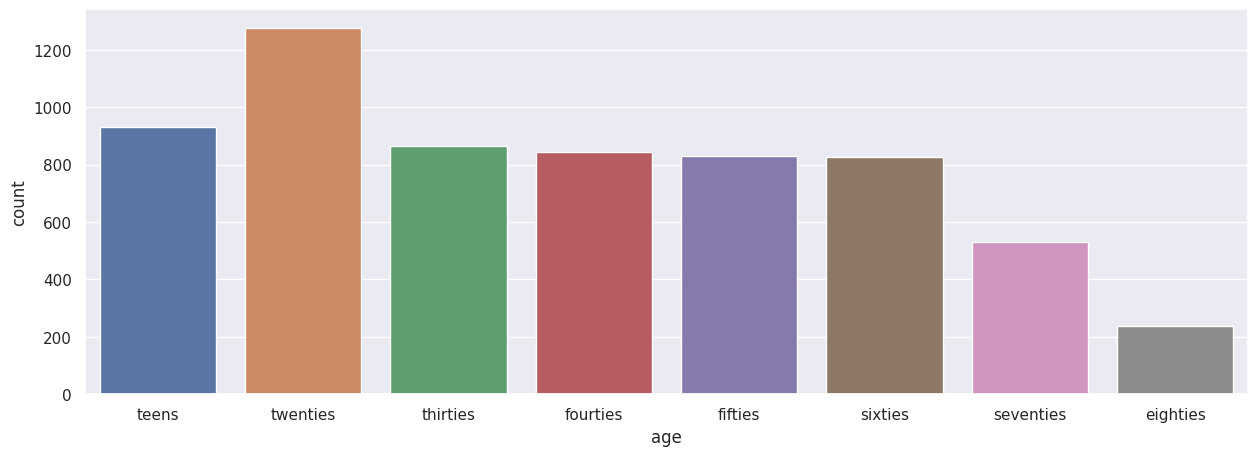

In [38]:
# Number of records according to different age categories

sns.set(rc={'figure.figsize':(15, 5)})

sns.countplot(
    x = 'age',
    data = df[df['age'].notna()],
    order = ['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties']
)

plt.savefig('/kaggle/working/models/age_dist_finalized_col_data.png')
plt.show()

In [39]:
# Different types of gender taken as per the data

df[df.gender.notna()].gender.unique().tolist()

['other', 'male', 'female']

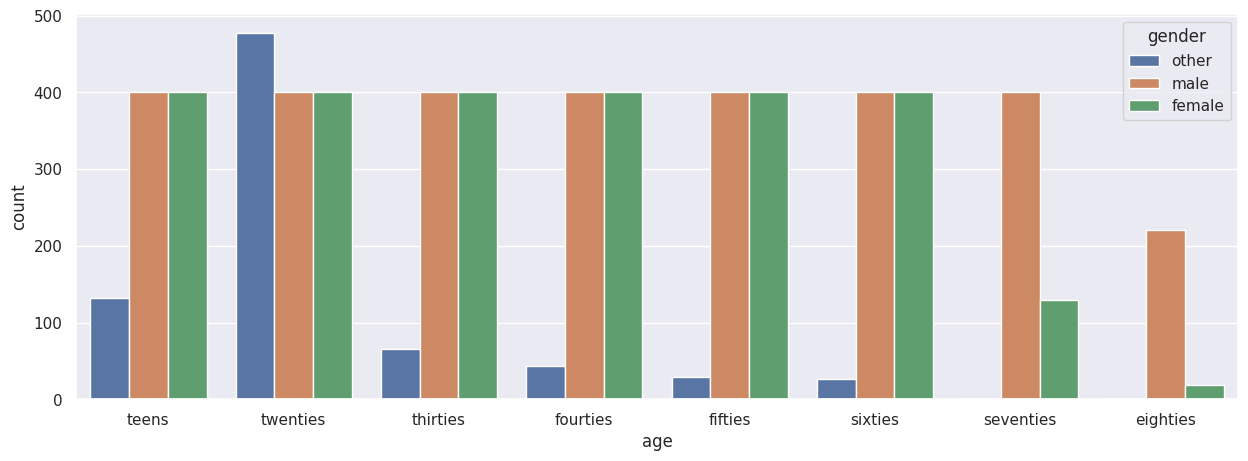

In [40]:
# Visualizing age with gender

sns.set(rc = {'figure.figsize':(15, 5)})

sns.countplot(
    x = 'age',
    hue = 'gender',
    data = df[df['age'].notna()],
    order = ['teens', 'twenties', 'thirties', 'fourties', 'fifties', 'sixties', 'seventies', 'eighties']
)

plt.savefig('/kaggle/working/models/gender_age_dist_finalized_col_data_2d.png')
plt.show()

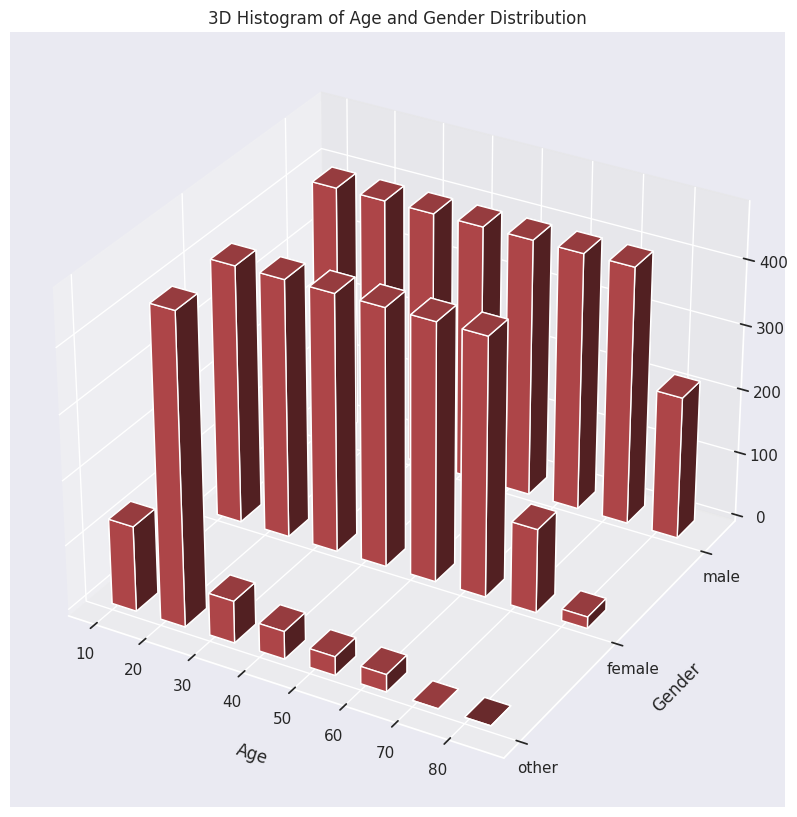

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

df = df[df['age'].notna() & df['gender'].notna()]

# Convert 'age' and 'gender' to categorical types
df['age'] = pd.Categorical(df['age'], categories=[
    'teens', 'twenties', 'thirties', 'fourties', 'fifties', 
    'sixties', 'seventies', 'eighties'
], ordered=True)
df['gender'] = pd.Categorical(df['gender'], categories=['other', 'female', 'male'], ordered=True)

# Group by 'age' and 'gender' and count occurrences
age_gender_counts = df.groupby(['age', 'gender']).size().reset_index(name='count')

# Pivot to create a matrix of counts for each combination of 'age' and 'gender'
pivot_table = age_gender_counts.pivot(index='gender', columns='age', values='count').fillna(0)

# Use the categorical codes for positions
xpos, ypos = np.meshgrid(pivot_table.columns.codes, pivot_table.index.codes)
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

# Count is the z value (height of the bar)
dz = pivot_table.values.flatten()

# Set the bar width and depth to 0.5
dx = 0.5
dy = 0.2

# Create the 3D plot
fig = plt.figure(figsize=(10, 16))
ax = fig.add_subplot(111, projection='3d')

# Plot the bars
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='r', zsort='average')

pivot_table.rename(columns={'teens': 10, 'twenties': 20, 'thirties': 30,
                           'fourties': 40, 'fifties': 50, 'sixties': 60, 
                           'seventies': 70, 'eighties': 80}, inplace=True)

# Set the tick labels
ax.set_xticks(range(len(pivot_table.columns)))
ax.set_xticklabels(pivot_table.columns.tolist())

ax.set_yticks(range(len(pivot_table.index)))
ax.set_yticklabels(pivot_table.index.tolist())

# Label the axes
ax.set_xlabel('\n\nAge')
ax.set_ylabel('\n\nGender')
# ax.set_zlabel('Count')

# Title for the plot
ax.set_title('3D Histogram of Age and Gender Distribution')

# Display the plot
plt.savefig('/kaggle/working/models/gender_age_dist_finalized_col_data_3d.png')
plt.show()


In [42]:
# Cleaned data shape

data = df
print("Final Data shaped:")
data.shape

Final Data shaped:


(6343, 3)

In [43]:
# Converting to numerical data

encoding = {
    "gender": {
        "female": 0,
        "male": 1,
        "other": 2,
    },
    "age": {
        "teens": 1,
        "twenties": 2,
        "thirties": 3,
        "fourties": 4,
        "fifties": 5,
        "sixties": 6,
        "seventies": 7,
        "eighties": 8,
    }
}

data = data.replace(encoding)
data.head()

,filename,age,gender
226,cv-valid-train/sample-000639.mp3,2,2
359,cv-valid-train/sample-001011.mp3,1,2
463,cv-valid-train/sample-001297.mp3,2,2
478,cv-valid-train/sample-001325.mp3,2,2
543,cv-valid-train/sample-001477.mp3,2,2


In [44]:
data.reset_index(inplace=True)

In [45]:
data.drop(columns=['index'], inplace=True)
data

,filename,age,gender
0,cv-valid-train/sample-000639.mp3,2,2
1,cv-valid-train/sample-001011.mp3,1,2
2,cv-valid-train/sample-001297.mp3,2,2
3,cv-valid-train/sample-001325.mp3,2,2
4,cv-valid-train/sample-001477.mp3,2,2
...,...,...,...
6338,cv-valid-train/sample-143002.mp3,8,0
6339,cv-valid-train/sample-149167.mp3,8,0
6340,cv-valid-train/sample-169383.mp3,8,0
6341,cv-valid-train/sample-171720.mp3,8,0


## 3. Feature Engineering

### Feature Extraction

We extract the following features:
The following features are related to audio quality through which the model will learn more effectively.  

**Spectral Centroid**: each frame of a magnitude spectrogram is normalized and treated as a distribution over frequency bins, from which the mean (centroid) is extracted per frame  

**Spectral Bandwidth**: compute 2nd-order spectral bandwidth  

**Spectral Rolloff**: the center frequency for a spectrogram bin such that at least roll_percent (0.85 by default) of the energy of the spectrum in this frame is contained in this bin and the bins below  

**Mel Frequency Cepstral Coefficients (MFCCs)**: a small set of 20 features that describe the overall shape of a spectral envelope  

### Librosa package  

Librosa is a Python package for music and audio analysis. It provides the building blocks necessary to create the music information retrieval systems. Librosa helps to visualize the audio signals and also do the feature extractions in it using different signal processing techniques.

In [ ]:
ds_path = "/kaggle/input/common-voice/cv-valid-train/"

def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    return audio + noise_factor * noise

def change_volume(audio, volume_factor=1.5):
    return audio * volume_factor

def random_crop(audio, sr, duration=2):
    if len(audio) > duration * sr:
        start = np.random.randint(0, len(audio) - duration * sr)
        return audio[start:start + duration * sr]
    else:
        return audio

def feature_extraction(filename, sampling_rate=48000, augment=0):
    path = "{}{}".format(ds_path, filename)
    features = list()
    audio, _ = librosa.load(path, sr=sampling_rate)

    if augment==1:
        audio = add_noise(audio)
    elif augment==2:
        audio = change_volume(audio, volume_factor=1.2)
    elif augment==3:
        audio = random_crop(audio, sampling_rate, duration=3)
    elif augment==4:
        audio = add_noise(audio)
        audio = change_volume(audio, volume_factor=1.2)
    elif augment==5:
        audio = change_volume(audio, volume_factor=1.2)
        audio = random_crop(audio, sampling_rate, duration=3)
    elif augment==6:
        audio = add_noise(audio)
        audio = random_crop(audio, sampling_rate, duration=3)

    gender = data[data['filename'] == filename].gender.values[0]
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
    features.append(gender)
    features.append(spectral_centroid)
    features.append(spectral_bandwidth)
    features.append(spectral_rolloff)
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
    for el in mfcc:
        features.append(np.mean(el))
    
    return features

def create_df_features(orig):
    new_rows = list()
    tot_rows = len(orig) - 1
    stop_counter = 55001

    for idx, row in orig.iterrows():
        if idx >= stop_counter: break
        print("\r", end="")
        print("{}/{}".format(idx, tot_rows), end="", flush=True)

        if (row['gender'] == 0 and row['age'] == 'seventies' and row['age'] == 'eighties'):
            for augment_type in range(1, 4):
                features = feature_extraction(row['filename'], augment=augment_type)
                features.append(row['age'])
                new_rows.append(features)
        if (row['gender'] == 2 and row['age'] != 20):
            for augment_type in range(1, 7):
                features = feature_extraction(row['filename'], augment=augment_type)
                features.append(row['age'])
                new_rows.append(features)
        else:
            features = feature_extraction(row['filename'], augment=0)
            features.append(row['age'])
            new_rows.append(features)
        

    col_names = ["gender", "spectral_centroid", "spectral_bandwidth", "spectral_rolloff"] + \
                ["mfcc{}".format(i) for i in range(1, 21)] + \
                ["age"]

    return pd.DataFrame(new_rows, columns=col_names)

# Use the dataframe
df_features = create_df_features(data)
df_features.head()

In [ ]:
temp = df_features

In [ ]:
df_features = temp

In [ ]:
# len(df_features.query("gender == 2 and age == 2")), len(df_features) - 

rough = df_features.query("gender == 2 and age == 1").sample(400)

df_features = df_features.query("not (gender == 2 and age == 1)")

df_features = pd.concat([
    df_features.query("gender != 2 or age != 2"),
    df_features.query("gender == 2 and age == 2").sample(400),
    rough,
])

len(df_features)

In [ ]:
df_features.reset_index(inplace=True)

In [ ]:
df_features.drop(columns=['level_0', 'index'], inplace=True)
df_features

In [ ]:
df_features.to_csv("/kaggle/working/final_data_set.csv")
df_features.head()

In [ ]:
# Visualizing age with gender

sns.set(rc = {'figure.figsize':(15, 5)})

sns.countplot(
    x = 'age',
    hue = 'gender',
    data = df_features,
    order = [1, 2, 3, 4, 5, 6, 7, 8]
)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

df = df_features

# Convert 'age' and 'gender' to categorical types
df['age'] = pd.Categorical(df['age'], categories=[
    1, 2, 3, 4, 5, 6, 7, 8
], ordered=True)
df['gender'] = pd.Categorical(df['gender'], categories=[2, 1, 0], ordered=True)

# Group by 'age' and 'gender' and count occurrences
age_gender_counts = df.groupby(['age', 'gender']).size().reset_index(name='count')

# Pivot to create a matrix of counts for each combination of 'age' and 'gender'
pivot_table = age_gender_counts.pivot(index='gender', columns='age', values='count').fillna(0)

# Use the categorical codes for positions
xpos, ypos = np.meshgrid(pivot_table.columns.codes, pivot_table.index.codes)
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

# Count is the z value (height of the bar)
dz = pivot_table.values.flatten()

# Set the bar width and depth to 0.5
dx = 0.5
dy = 0.2

# Create the 3D plot
fig = plt.figure(figsize=(10, 16))
ax = fig.add_subplot(111, projection='3d')

# Plot the bars
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='r', zsort='average')

# pivot_table.rename(columns={'teens': 10, 'twenties': 20, 'thirties': 30,
#                            'forties': 40, 'fifties': 50, 'sixties': 60, 
#                            'seventies': 70, 'eighties': 80}, inplace=True)

# Set the tick labels
ax.set_xticks(range(len(pivot_table.columns)))
ax.set_xticklabels(pivot_table.columns.tolist())

ax.set_yticks(range(len(pivot_table.index)))
ax.set_yticklabels(pivot_table.index.tolist())

# Label the axes
ax.set_xlabel('\n\nAge')
ax.set_ylabel('\n\nGender')
# ax.set_zlabel('Count')

# Title for the plot
ax.set_title('3D Histogram of Age and Gender Distribution')

# Display the plot
plt.show()


In [4]:
os.mkdir('models')

In [5]:
df_features = pd.read_csv("/kaggle/input/final-data/final_data_set.csv").drop(columns=['Unnamed: 0'])
df_features = df_features.sample(frac=1)
df_features

,gender,spectral_centroid,spectral_bandwidth,spectral_rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,age
6781,2,7938.668198,6846.352154,15953.142323,-269.669919,59.056926,13.695578,6.502818,13.666386,4.787874,...,-4.167040,-2.621910,3.480807,1.532734,-4.446028,-2.468645,1.363038,-1.743651,-6.265558,2
5559,0,2656.655323,2463.528428,5251.792279,-382.370514,73.678047,-14.065327,6.520857,1.844866,-7.726208,...,-7.193655,-10.339008,-3.245398,-0.979104,-6.575956,-6.710247,0.647549,2.410211,-1.031391,6
3609,1,1504.610047,1294.680715,2643.249046,-415.731171,96.586571,10.782086,8.249093,-4.563363,-14.666072,...,-2.757276,0.577351,-8.183746,-1.738211,0.946452,-9.223489,-5.786263,0.844199,-3.562263,4
1030,1,3808.553591,3270.286163,7134.444963,-381.004883,120.208763,-16.215033,18.836798,2.579969,24.042915,...,-0.030381,0.350328,-8.942291,1.437145,-2.970229,-3.364645,0.046688,5.955129,-6.190651,1
2411,1,1649.189332,1746.641657,3178.415106,-375.224518,135.845520,-14.881020,3.429722,20.491819,-0.105843,...,-4.973011,1.105253,-3.223364,-0.748005,-1.173380,-7.637737,-1.570223,1.750408,-3.354231,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2072,1,3178.830273,2393.028548,5621.276285,-349.326874,115.659325,-43.578682,28.523323,29.078989,1.003517,...,4.846975,-5.864930,1.166636,-4.190581,-5.399462,2.503933,2.734877,-1.407804,-5.230567,3
3221,1,3228.197699,3377.755968,6631.229904,-425.045105,118.143661,-1.190895,46.065754,-7.762699,21.047129,...,5.774910,8.016096,-4.522544,-3.004082,-8.076645,3.177104,-1.039652,4.519460,-7.025279,5
582,2,9554.208016,7288.027589,18841.112659,-311.498038,38.277674,19.189265,14.622245,11.886556,7.587476,...,-1.634840,-2.370898,-3.522047,-3.222190,-2.641503,-1.557597,-2.988672,-4.927073,-3.331789,3
6807,2,9600.287988,7431.740715,19169.215426,-323.844219,31.744305,21.829349,17.515364,13.119767,7.602087,...,-5.946850,-4.096369,-1.921931,-2.459726,-2.442241,-0.742167,-0.219256,-0.071017,0.642160,2


In [8]:
# Gender Model

gender_X = df_features.drop(columns=['gender', 'age'])
gender_y = df_features['gender']

gender_X_train, gender_X_test, gender_y_train, gender_y_test = train_test_split(gender_X, gender_y, test_size=0.2, random_state=42)

gender_results = pd.DataFrame(columns=['Gender Model', 'Training Time', 'Train Accuracy', 'Test Accuracy'])

gender_ml_models = [
    ('Linear Regression', LinearRegression()),
    ('Logistic Regression', LogisticRegression()),
    ('SVM', SVC()),
    ('Random Forest', RandomForestClassifier()),
    ('K-NN', KNeighborsClassifier()),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('Bernoulli Naive Bayes', BernoulliNB()),
    ('Decision Tree', DecisionTreeClassifier())
]

for name, model in gender_ml_models:
    start_time = time.time()
    model.fit(gender_X_train, gender_y_train)
    
    with open(f'models/gender_{name}.pkl', 'wb') as file:
        pkl.dump(model, file)
    
    end_time = time.time()
    train_time = end_time - start_time
    gender_y_pred_train = np.round(model.predict(gender_X_train))
    gender_y_pred_test = np.round(model.predict(gender_X_test))
    train_acc = accuracy_score(gender_y_train, gender_y_pred_train)
    test_acc = accuracy_score(gender_y_test, gender_y_pred_test)
    gender_results.loc[len(gender_results)] = {
        'Gender Model': name, 
        'Training Time': train_time, 
        'Train Accuracy': train_acc, 
        'Test Accuracy': test_acc}
    
gender_y_train = to_categorical(gender_y_train, num_classes=3)
gender_y_test = to_categorical(gender_y_test, num_classes=3)
    
gender_dl_models = [
    (
        'Simple Dense 1',
        tf.keras.models.Sequential([
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(3, activation='softmax')
        ])
    ),
    (
        'Simple Dense 2',
        tf.keras.models.Sequential([
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(3, activation='softmax')
        ])
    ),
    (
        'Simple Dense 3',
        tf.keras.models.Sequential([
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(3, activation='softmax')
        ])
    ),
]

for name, model in gender_dl_models:
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    model.fit(gender_X_train, gender_y_train, verbose=0, epochs=100, batch_size=16)
    
    model.save(f"models/gender_{'_'.join(name.split())}.h5")
    
    end_time = time.time()
    train_time = end_time - start_time

    train_loss, train_acc = model.evaluate(gender_X_train, gender_y_train, verbose=0)
    test_loss, test_acc = model.evaluate(gender_X_test, gender_y_test, verbose=0)

    gender_y_pred_test = np.argmax(model.predict(gender_X_test, verbose=0), axis=1)

    gender_results.loc[len(gender_results)] = {
        'Gender Model': name, 
        'Training Time': train_time, 
        'Train Accuracy': train_acc, 
        'Test Accuracy': test_acc
    }

In [9]:
gender_results

,Gender Model,Training Time,Train Accuracy,Test Accuracy
0,Linear Regression,0.018781,0.702312,0.727396
1,Logistic Regression,0.239541,0.640598,0.653977
2,SVM,1.871184,0.529412,0.530931
3,Random Forest,2.192601,1.000000,0.869477
4,K-NN,0.004514,0.735294,0.621346
5,Gaussian Naive Bayes,0.005117,0.700612,0.693406
6,Bernoulli Naive Bayes,0.005530,0.579395,0.592114
7,Decision Tree,0.166405,1.000000,0.789939
8,Simple Dense 1,83.751026,0.705032,0.716519
9,Simple Dense 2,88.221094,0.823529,0.817131


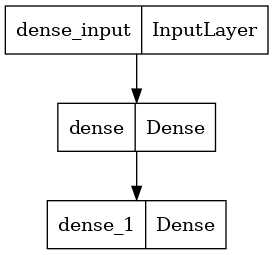

In [19]:
from tensorflow.keras.utils import plot_model

plot_model(gender_dl_models[0][1], to_file='/kaggle/working/models/model_1.png')

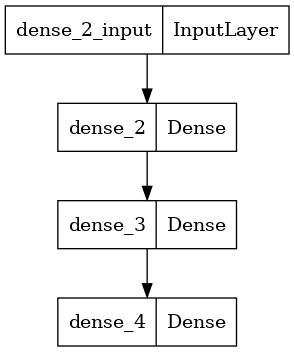

In [18]:
plot_model(gender_dl_models[1][1], to_file='/kaggle/working/models/model_2.png')

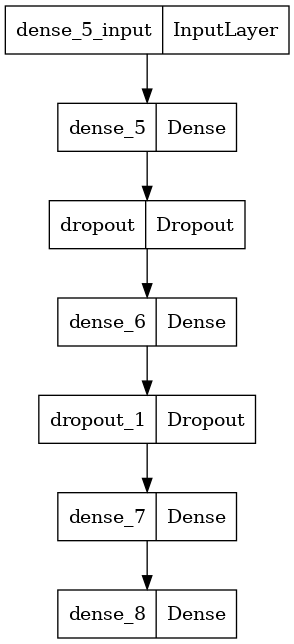

In [17]:
plot_model(gender_dl_models[2][1], to_file='/kaggle/working/models/model_3.png')

In [21]:
# Age Model

age_X = df_features.drop(columns=['gender', 'age'])
age_y = df_features['age']

age_X_train, age_X_test, age_y_train, age_y_test = train_test_split(age_X, age_y, test_size=0.2, random_state=42)

age_results = pd.DataFrame(columns=['age Model', 'Training Time', 'Train Accuracy', 'Test Accuracy'])

age_ml_models = [
    ('Linear Regression', LinearRegression()),
    ('Logistic Regression', LogisticRegression()),
    ('SVM', SVC()),
    ('Random Forest', RandomForestClassifier()),
    ('K-NN', KNeighborsClassifier()),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('Bernoulli Naive Bayes', BernoulliNB()),
    ('Decision Tree', DecisionTreeClassifier())
]

for name, model in age_ml_models:
    start_time = time.time()
    model.fit(age_X_train, age_y_train)
    
    with open(f"models/age_{'_'.join(name.split())}.pkl", 'wb') as file:
        pkl.dump(model, file)
    
    end_time = time.time()
    train_time = end_time - start_time
    age_y_pred_train = np.round(model.predict(age_X_train))
    age_y_pred_test = np.round(model.predict(age_X_test))
    train_acc = accuracy_score(age_y_train, age_y_pred_train)
    test_acc = accuracy_score(age_y_test, age_y_pred_test)
    age_results.loc[len(age_results)] = {
        'age Model': name, 
        'Training Time': train_time, 
        'Train Accuracy': train_acc, 
        'Test Accuracy': test_acc}
    
age_y_train = to_categorical(age_y_train, num_classes=9)
age_y_test = to_categorical(age_y_test, num_classes=9)
    
age_dl_models = [
    (
        'Simple Dense 1',
        tf.keras.models.Sequential([
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(9, activation='softmax')
        ])
    ),
    (
        'Simple Dense 2',
        tf.keras.models.Sequential([
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(9, activation='softmax')
        ])
    ),
    (
        'Simple Dense 3',
        tf.keras.models.Sequential([
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(9, activation='softmax')
        ])
    )
]

for name, model in age_dl_models:
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    start_time = time.time()
    model.fit(age_X_train, age_y_train, verbose=0, epochs=100, batch_size=16)
    end_time = time.time()
    
    model.save(f"models/age_{'_'.join(name.split())}.h5")
    train_time = end_time - start_time

    train_loss, train_acc = model.evaluate(age_X_train, age_y_train, verbose=0)
    test_loss, test_acc = model.evaluate(age_X_test, age_y_test, verbose=0)

    age_y_pred_test = np.argmax(model.predict(age_X_test, verbose=0), axis=1)

    age_results.loc[len(age_results)] = {
        'age Model': name, 
        'Training Time': train_time, 
        'Train Accuracy': train_acc, 
        'Test Accuracy': test_acc}

In [22]:
age_results

,age Model,Training Time,Train Accuracy,Test Accuracy
0,Linear Regression,0.010797,0.162870,0.157036
1,Logistic Regression,0.442925,0.203502,0.204623
2,SVM,2.654402,0.230364,0.223657
3,Random Forest,2.803937,1.000000,0.710401
4,K-NN,0.004646,0.528222,0.323589
5,Gaussian Naive Bayes,0.005336,0.272526,0.265126
6,Bernoulli Naive Bayes,0.006343,0.280007,0.281441
7,Decision Tree,0.264533,1.000000,0.478586
8,Simple Dense 1,80.852768,0.219143,0.218219
9,Simple Dense 2,88.668618,0.164060,0.159755


In [23]:
gender_results.to_csv('models/gender_results.csv')
age_results.to_csv('models/age_results.csv')

In [47]:
import shutil

def zip_folder(folder_path, zip_path):
    shutil.make_archive(zip_path, 'zip', folder_path)

folder_path = 'models'
zip_path = '/kaggle/working/zipped'
zip_folder(folder_path, zip_path)

In [ ]:
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle as pkl

def feature_extraction(filename, sampling_rate=48000, augment=0):
    path = filename
    features = list()
    audio, _ = librosa.load(path, sr=sampling_rate)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
    features.append(spectral_centroid)
    features.append(spectral_bandwidth)
    features.append(spectral_rolloff)
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
    for el in mfcc:
        features.append(np.mean(el))
    
    return features

def predict_gender(filename, model):
    features = feature_extraction(filename)
    features = np.array(features).reshape(1, -1)
    prediction = model.predict(features)
    predicted_class = np.argmax(prediction, axis=1)
    genders = {0: 'Male', 1: 'Female', 2: 'Other'}
    return genders[predicted_class[0]]

def predict_age(filename, model):
    features = feature_extraction(filename)
    features = np.array(features).reshape(1, -1)
    prediction = model.predict(features)
    predicted_class = np.argmax(prediction, axis=1)
    genders = {1: 'Teen', 2: 'Twenties', 0: '---', 3: 'Thirties', 4: 'Fourties', 5: 'Fifties', 6: 'Sixties', 7: 'Seventies', 8: 'Eighties'}
    return genders[predicted_class[0]]


gender_model = tf.keras.models.load_model('/kaggle/working/models/gender_Simple_Dense_1.h5')
age_model = tf.keras.models.load_model('/kaggle/working/models/age_Simple_Dense_2.h5')

test_filename = '/kaggle/input/recording/recording0.wav'
predicted_gender = predict_gender(test_filename, gender_model)
predicted_age = predict_age(test_filename, age_model)

print(f'Predicted Gender: {predicted_gender}')
print(f'Predicted Age: {predicted_age}')

In [ ]:
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle as pkl

def feature_extraction(filename, sampling_rate=48000, augment=0):
    path = filename
    features = list()
    audio, _ = librosa.load(path, sr=sampling_rate)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
    features.append(spectral_centroid)
    features.append(spectral_bandwidth)
    features.append(spectral_rolloff)
    
    mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate)
    for el in mfcc:
        features.append(np.mean(el))
    
    return features

def predict_gender(filename, model):
    features = feature_extraction(filename)
    features = np.array(features).reshape(1, -1)
    prediction = model.predict(features)
    predicted_class = np.round(prediction)
    genders = {0: 'Male', 1: 'Female', 2: 'Other'}
    return genders[predicted_class[0]]

def predict_age(filename, model):
    features = feature_extraction(filename)
    features = np.array(features).reshape(1, -1)
    prediction = model.predict(features)
    predicted_class = np.round(prediction)
    genders = {1: 'Teen', 2: 'Twenties', 0: '---', 3: 'Thirties', 4: 'Fourties', 5: 'Fifties', 6: 'Sixties', 7: 'Seventies', 8: 'Eighties'}
    return genders[predicted_class[0]]


gender_model = pkl.load(open('/kaggle/working/models/gender_Decision Tree.pkl', 'rb'))
age_model = pkl.load(open('/kaggle/working/models/gender_Decision Tree.pkl', 'rb'))

test_filename = '/kaggle/input/newrec/sample_voice.wav'
predicted_gender = predict_gender(test_filename, gender_model)
predicted_age = predict_age(test_filename, age_model)

print(f'Predicted Gender: {predicted_gender}')
print(f'Predicted Age: {predicted_age}')